In [25]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import isclose

In [23]:
#Defining Functions / Model

def model(t, M, K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z):
    
    N = M[0] #Nutrients
    P = M[1] #Phytoplankton
    Z = M[2] #Zooplankton 
    
    #Defing Phytoplankton equation
    phyto_growth = P * V_max * (N / (K_N + N)) #Monod
    phyto_mort = P * λ_P
    grazing = P * g * Z / K_P
                        
    dPdt = phyto_growth - phyto_mort - grazing
                        
    #Defing Zooplankton equation
    zoo_assim_rate = γ_Z
    zoo_mort = Z * λ_Z
                        
    dZdt = zoo_assim_rate * grazing - zoo_mort
    
    #Defing Nutrient equation
    phyto_remineral = μ_P * phyto_mort
    
    messy_eating = (1 - zoo_assim_rate) * grazing
    zoo_remineral = μ_Z * (messy_eating + zoo_mort)

    phyto_export = (1 - μ_P) * phyto_mort                  
    zoo_export = (1 - μ_Z) * (messy_eating + zoo_mort)
    export = phyto_export + zoo_export
    
    dNdt = - phyto_growth + phyto_remineral + zoo_remineral + export
    
    return dNdt, dPdt, dZdt

                
#Initial Conditions N0, P0, Z0
m0 = [10, .6 , .6]  #mmol m^-3, starting at the P pop-density require to sustain Z
             
#Args
K_N = .1 #mmol m^-3

V_max = 1.4 #d^-1
λ_P = .05 #d^-1
μ_P = .4

g = 1.4 #d^-1 
K_P = 2.8 #mmol m^-3
γ_Z = .4
λ_Z = .12 #d^-1
μ_Z = .4

#Solving for Solution, second argument time range in days
max_stp = .1
sol = solve_ivp(model, [0, 26], m0, args=(K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), max_step=max_stp)
#cycle = solve_ivp(model, [0, 5475], m0, args=(K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), max_step=max_stp)

high_tol_sol = solve_ivp(model, [0, 26], m0, args=(K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), max_step=max_stp, rtol=10**-5, atol=10**-8)
higher_tol_sol = solve_ivp(model, [0, 26], m0, args=(K_N, V_max, λ_P, μ_P, g, K_P, γ_Z, λ_Z, μ_Z), max_step=max_stp, rtol=10**-6, atol=10**-9)

Insensitive to decrease in relative and absolute tol?

In [24]:
len(higher_tol_sol.y[0]), len(high_tol_sol.y[0]), len(sol.y[0])

(262, 262, 261)

In [25]:
N_diff = [abs(higher_tol_sol.y[0][i] - high_tol_sol.y[0][i]) for i in range(len(higher_tol_sol.t))]
P_diff = [abs(higher_tol_sol.y[1][i] - high_tol_sol.y[1][i]) for i in range(len(higher_tol_sol.t))]
Z_diff = [abs(higher_tol_sol.y[2][i] - high_tol_sol.y[2][i]) for i in range(len(higher_tol_sol.t))]

max(N_diff), max(P_diff), max(Z_diff)

(0.07796025391498596, 0.09208369346518452, 0.06819222522382784)

In [27]:
#where is the largest error happening?
N_le = N_diff.index(max(N_diff))
P_le = P_diff.index(max(P_diff))
Z_le = Z_diff.index(max(Z_diff))

sol.t[N_le], sol.t[P_le], sol.t[Z_le]

(2.500000000000001, 3.600000000000002, 3.4000000000000017)

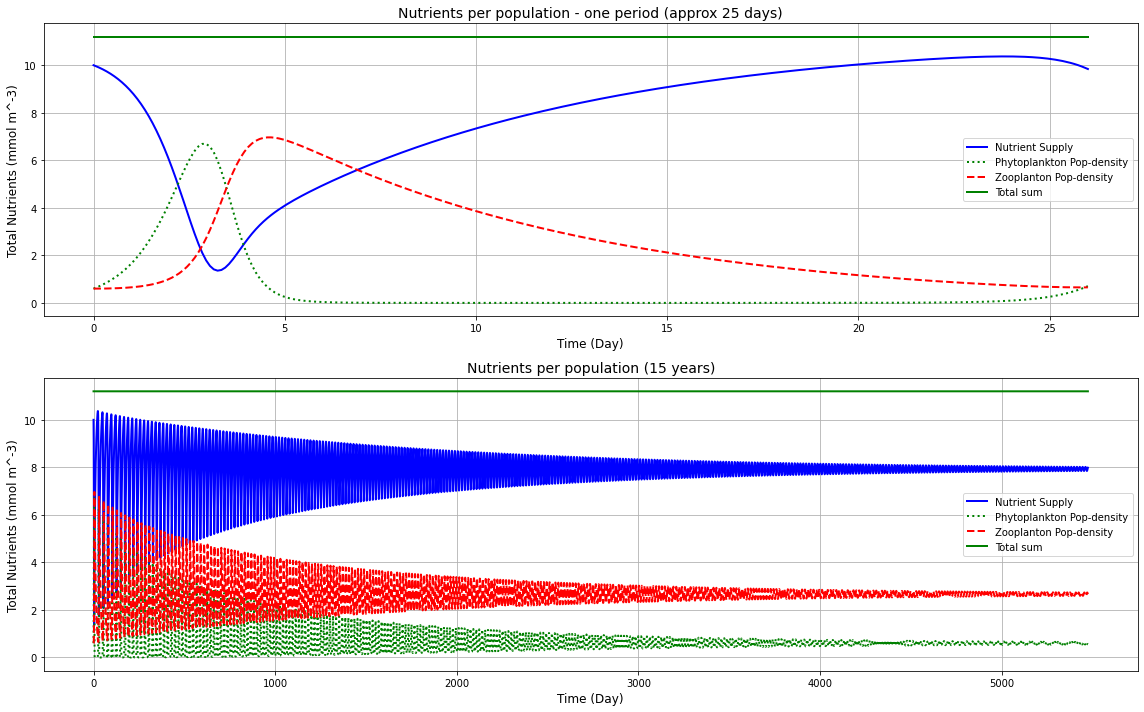

In [10]:
#Plot results
fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#One cycle
ax.plot(high_tol_sol.t, high_tol_sol.y[0], 'b', linewidth= 2, label='Nutrient Supply')
ax.plot(high_tol_sol.t, high_tol_sol.y[1], 'g:', linewidth = 2, label='Phytoplankton Pop-density')
ax.plot(high_tol_sol.t, high_tol_sol.y[2], 'r--', linewidth = 2, label='Zooplanton Pop-density')

ax.plot(high_tol_sol.t, high_tol_sol.y[0]+high_tol_sol.y[1]+high_tol_sol.y[2], 'g', linewidth = 2, label='Total sum')

ax.set_xlabel('Time (Day)', fontsize = 12)
ax.set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax.set_title('Nutrients per population - one period (approx 25 days)',fontsize = 14)
ax.legend()
ax.grid()


#Three Cycles
ax2.plot(cycle.t, cycle.y[0], 'b', linewidth= 2, label='Nutrient Supply')
ax2.plot(cycle.t, cycle.y[1], 'g:', linewidth = 2, label='Phytoplankton Pop-density')
ax2.plot(cycle.t, cycle.y[2], 'r--', linewidth = 2, label='Zooplanton Pop-density')

ax2.plot(cycle.t, cycle.y[0]+cycle.y[1]+cycle.y[2], 'g', linewidth = 2, label='Total sum')

ax2.set_xlabel('Time (Day)', fontsize = 12)
ax2.set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
ax2.set_title('Nutrients per population (15 years)',fontsize = 14)
ax2.legend()
ax2.grid()

fig.tight_layout()
plt.show()

In [22]:
#Finding the equalibrium of all state variables, assuming only one max and min.
state_vars = ["Nutrients", "Phytoplankton", "Zooplankton"]   
groups = {}

for i in range(3):
    solutions = sol.y[i]
    
    max_y = np.max(solutions) #find max and min of each state variable 
    min_y = np.min(solutions)

    #Find time at which max and min happen (index placement)
    eq_max = np.where(solutions == max_y)[0][0]
    eq_min = np.where(solutions == min_y)[0][0]

    groups[state_vars[i] + '_max'] = [sol.t[eq_max], sol.y[0][eq_max], sol.y[1][eq_max], sol.y[2][eq_max]]
    groups[state_vars[i] + '_min'] = [sol.t[eq_min], sol.y[0][eq_min], sol.y[1][eq_min], sol.y[2][eq_min]]
    
    t_max = groups[state_vars[i] + '_max'][0]
    N_max = groups[state_vars[i] + '_max'][1]
    P_max = groups[state_vars[i] + '_max'][2]
    Z_max = groups[state_vars[i] + '_max'][3]
    
    t_min = groups[state_vars[i] + '_min'][0]
    N_min = groups[state_vars[i] + '_min'][1]
    P_min = groups[state_vars[i] + '_min'][2]
    Z_min = groups[state_vars[i] + '_min'][3]
                                      
    print("At max " + state_vars[i] + f": t = {t_max: .3f}, N = {N_max: .3f}, P = {P_max: .3f}, Z = {Z_max: .3f} ")
    print("At min " + state_vars[i] + f": t = {t_min: .3f}, N = {N_min: .3f}, P = {P_min: .3f}, Z = {Z_min: .3f} ")
    print()

At max Nutrients: t =  23.800, N =  10.370, P =  0.079, Z =  0.750 
At min Nutrients: t =  3.300, N =  1.363, P =  5.744, Z =  4.093 

At max Phytoplankton: t =  2.900, N =  1.917, P =  6.705, Z =  2.578 
At min Phytoplankton: t =  13.100, N =  8.537, P =  0.000, Z =  2.662 

At max Zooplankton: t =  4.600, N =  3.639, P =  0.595, Z =  6.967 
At min Zooplankton: t =  0.000, N =  10.000, P =  0.600, Z =  0.600 



In [ ]:
# Defining equations
def gamma_P(N, K_N):
    '''Monod growth function for specified nutrient.
       return: Monod (flt)
    '''
    return N / (K_N + N)

def grazing_func(p_pop_den, z_pop_den, grazing_rate, half_sat):
    ''' Grazing function, assuming we are in the linear portion of 
        the monod feeding curve.
        
        return: portion of the phytoplankton population lost to grazing (flt)
    '''
    return grazing_rate * (p_pop_den / half_sat) * z_pop_den


def Gamma_P(pop_den, max_growth_rate, nutr_monod_func, mortality, grazing_func):
    ''' Population density of Phytoplankton over time (steady state)'''
    paren = max_growth_rate * nutr_monod_func - mortality - (grazing_func / pop_den)
    return pop_den * paren

def Gamma_Z(pop_den, growth_rate, grazing_func, mortality):
    ''' Population density of Zooplankton over time (steady state)'''
    paren = growth_rate * (grazing_func / pop_den) - mortality
    return pop_den * paren

def Gamma_N_closed(p_pop_den, max_growth, nutr_monod_func, p_mort,
           z_pop_den, z_assimilation, grazing_func, z_mort):
    
    '''Nutrient Supply Function'''
    
    from_phyto = p_pop_den * (-max_growth * nutr_monod_func + p_mort)
    
    from_zoo_paren = (1 - z_assimilation) * (grazing_func / z_pop_den) + z_mort
    from_zoo = z_pop_den * from_zoo_paren
    
    return from_phyto + from_zoo

In [ ]:
#Double checking Nutrient values with state equations

N_max = groups[state_vars[0] + '_max'][1]
P_max = groups[state_vars[0] + '_max'][2]
Z_max = groups[state_vars[0] + '_max'][3]

N_min = groups[state_vars[0] + '_min'][1]
P_min = groups[state_vars[0] + '_min'][2]
Z_min = groups[state_vars[0] + '_min'][3]
  
gam_N_max = round(Gamma_N_closed(P_max, V_max, gamma_P(N_max, K_N), λ_P, Z_max, γ_Z, grazing_func(P_max, Z_max, g, K_P), λ_Z), 5)
gam_N_min = round(Gamma_N_closed(P_min, V_max, gamma_P(N_min, K_N), λ_P, Z_min, γ_Z, grazing_func(P_min, Z_min, g, K_P), λ_Z), 5)

print(f"Γ_N evaluates to {gam_N_max} at the given values of N = {N_max: .3f}, P = {P_max: .3f}, and Z = {Z_max: .3f}")
print(f"Γ_N evaluates to {gam_N_min} at the given values of N = {N_min: .3f}, P = {P_min: .3f}, and Z = {Z_min: .3f}")
print()

#Double checking Phytoplankton values with state equations
N_max = groups[state_vars[1] + '_max'][1]
P_max = groups[state_vars[1] + '_max'][2]
Z_max = groups[state_vars[1] + '_max'][3]

N_min = groups[state_vars[1] + '_min'][1]
P_min = groups[state_vars[1] + '_min'][2]
Z_min = groups[state_vars[1] + '_min'][3]

gam_P_max = round(Gamma_P(P_max, V_max, gamma_P(N_max, K_N), λ_P, grazing_func(P_max, Z_max, g, K_P)), 5)
gam_P_min = round(Gamma_P(P_min, V_max, gamma_P(N_min, K_N), λ_P, grazing_func(P_min, Z_min, g, K_P)), 5)

print(f"Γ_P evaluates to {gam_P_max} at the given values of N = {N_max: .3f}, P = {P_max: .3f}, and Z = {Z_max: .3f}")
print(f"Γ_P evaluates to {gam_P_min} at the given values of N = {N_min: .3f}, P = {P_min: .3f}, and Z = {Z_min: .3f}")
print()

#Double checking Zooplankton values with state equations
N_max = groups[state_vars[2] + '_max'][1]
P_max = groups[state_vars[2] + '_max'][2]
Z_max = groups[state_vars[2] + '_max'][3]

N_min = groups[state_vars[2] + '_min'][1]
P_min = groups[state_vars[2] + '_min'][2]
Z_min = groups[state_vars[2] + '_min'][3]

gam_Z_max = round(Gamma_Z(Z_max, γ_Z, grazing_func(P_max, Z_max, g, K_P), λ_Z), 5)
gam_Z_min = round(Gamma_Z(Z_min, γ_Z, grazing_func(P_min, Z_min, g, K_P), λ_Z), 5)

print(f"Γ_Z evaluates to {gam_Z_max} at the given values of N = {N_max: .3f}, P = {P_max: .3f}, and Z = {Z_max: .3f}")
print(f"Γ_Z evaluates to {gam_Z_min} at the given values of N = {N_min: .3f}, P = {P_min: .3f}, and Z = {Z_min: .3f}")
print()

# Adding Light 

Our goal is to develope the classical NPZ model to illustrate the light supply may influence phytoplankton growth in the presence of a mixed layer. 

Ch.4 P4.14: We want to estimate the diurally (24hr) averaged light supply function $\gamma_P (I_0)$ at the surface of the ocean, defined $\langle \gamma_P (I_0) \rangle$. 

We assume that the noontime clear sky irradiance at the surface of the ocean at the equator $I_n = 1000 \; W m^{-2}$, and that the diurnal variation of the irradiance function $f(t)$ is given as a triangular function that increases linearly from 0 at 6am to 1 at noon, then back to 0 at 6pm, ie.

$$f(t) = \left\{
\begin{array}{l}
      1 - |\frac{t - 12}{6}|, \; 6 < t < 18; \\
      0, \; otherwise. \\
\end{array} 
\right. $$

a. We have $I_0 = f_{PAR} \cdot f(CL) \cdot f(t) \cdot I_n$ (4.2.13), 

where we assume $f_{PAR} = .4$ and $f(CL) = .8$. We want an equation for the surface irradiance, $I_0$ in terms of time $t$ in hours, with $t$ set to 0 at day break (6am). 

We need: $f(0) = 0, \; f(6) = 1,$ and $f(12) = 0$, then $f(t) = \left( 1 - \frac{|t - 6|}{6} \right)$, and we have 

$$I_0 = 320 \left( 1 - \frac{|t - 6|}{6} \right).$$

b. Using the Platt and Jassby formulation (4.2.16) $$\gamma_p(I_0) = \frac{I_0}{\sqrt{I_{k}^{2} + I_{0}^{2}}}$$ 

to calculate $\langle \gamma_P (I_0) \rangle$.

Assuming $V_{max} = 1.4 \; d^{-1}$ and $\alpha = .025 \; m^{2}/Wd$, from (4.2.17) we have 

$$I_k = \frac{V_{max}}{\alpha} = \frac{1.4}{.025} = 56 \; W m^{-2}.$$

We can solve this problem analytically by stepwise integration over the 24 hours of the day, starting with the first 6 hours of daylight and using the integral form $$\int_{a}^{b}\frac{x}{\sqrt{\alpha^2 + x^2} dx} = \left. \sqrt{\alpha^2 + x^2} \; \right\vert_{a}^{b}.$$

Therefore we have the diurally (24hr) averaged light supply function, split up the integral since its symetrical in the first 12 hrs,

$$ \int_{0}^{24}{\frac{I_0(t)}{\sqrt{I_{k}^{2} + I_{0}^{2}(t)}} dt } \; = \; 2 \; \int_{0}^{6}{\frac{I_0(t)}{\sqrt{I_{k}^{2} + I_{0}^{2}(t)}} dt } \; + \; \int_{12}^{24}{\frac{I_0(t)}{\sqrt{I_{k}^{2} + I_{0}^{2}(t)}} dt } \; = \; 2 \left[\sqrt{I_{k}^{2} + I_{0}^{2}(t)} \; \right]_{0}^{6} \; + \; 12 I_k$$


In [58]:
from math import sqrt, log

def t_func(t):
    """Triangle function defining irradiance, starting with t = 0,
    peak at hour 6, then back to 0 at hour 12."""
    
    if t < 12:
        return 1 - ((abs(t - 6) / 6))
    else:
        return 0
    

def surface_irrad(t_func, f_par, f_cl, I_n):
    """Surface irradiance defined by (4.2.13) in Sarmiento and Gruber"""
    
    return f_par * f_cl * t_func * I_n 


def int_(I_0, I_k):
    """Diurnal averaged light supply at the surface of the ocean,
    using the Platt and Jassby formulation (4.2.16)."""
    
    return sqrt(I_k ** 2 + I_0 ** 2)


hours = [i for i in range(24)]
f_par = .4
f_cl  = .8
I_n   = 1000
I_k   = 56


#Evaluated definite integral, divided by 24 for diural average
irrad_at_6hr = int_(surface_irrad(6, f_par, f_cl, I_n), I_k)
irrad_at_0hr = int_(surface_irrad(0, f_par, f_cl, I_n), I_k)
irrad_at_night = 12 * I_k

diurnal_average = (2 * (irrad_at_6hr - irrad_at_0hr) + irrad_at_night) / 24
print(str(diurnal_average) + " W/m^2")

183.40137442142122 W/m^2


Ch.4 P4.15: We want to find the depth at which the diurnally averaged light supply $\langle \gamma_P (I_0) \rangle$ crosses the threshold required for phytoplankton to achive minimum concentration for which zooplankton can survive (.6 mmol $m^{-3}$).

a. Assuming a temperature $10^{\circ}C$, mortality rate $\lambda_P = 0.05 \; d^{-1}$, $K_N = .1 \; mmol \; m^{-3}$, with $N_T = 10 \; mmol \; m^{-3}$.

Assuming no grazing, the general sorce-minus-sinks formula for P (4.2.7) is defined as follows:

\begin{align}
    SMS(P) &= V_P(T) \cdot \gamma_P(I,N) \cdot P - \lambda_P \cdot P \\
    &= V_P(T) \cdot \gamma_P(I) \cdot \gamma_P(N) \cdot P - \lambda_P \cdot P
\end{align}

What we know: 

The effect of temperature on the maximum rate of photosynthesis (4.2.8) defined by Eppley[1972], is as follows:

\begin{align}
V_P(T) &= a \cdot b^{cT} \\
a &= .6 \; d^{-1} \\
b &= 1.066 \\
c &= 1 \; (^{\circ}C)^{-1} 
\end{align}

Then in this case, $V_P(10) = .6 \cdot 1.066^{10} = 1.1369026984553776$.

Given $P = .6 \; mmol \; m^{-3}$ and $N_T = 10 \; mmol \; m^{-3}$, we see from (4.3.8) $N = N_T - P = 10 - .6 = 9.4 \; mmol \; m^{-3}$.

Then from (4.2.11) $\; \gamma_P(N) = \frac{N}{K_N + N} = \frac{9.4}{.1 + 9.4} = 0.9894736842105264. $

We are in steady-state, so we can assume that $SMS(P) = 0$.

Combining all these pieces together, we see

$0 = V_P(T) \cdot \gamma_P(I,N) \cdot P - \lambda_P \cdot P$

\begin{align}
\Rightarrow \quad \gamma_P(I) &= \frac{\lambda_P \cdot P}{V_P(T) \cdot \gamma_P(N) \cdot P}\\
&= \frac{\lambda_P}{V_P(10) \cdot \gamma_P(9.4)} \\
&= \frac{.05}{1.1369026984553776 \cdot 0.9894736842105264} \\ \\
&= 0.04444700057645289
\end{align}

b. We want to find at what depth $H$ in the ocean will the diurnally averaged light sullply function cross the threshold esimated above, assuming $P$ is constant with depth and a total attenuation coeffiecient of $.12 \; m^{-1}$.

From (4.2.14), we see the irradience at depth $z$ can be represented by an equation of the form 

$$\langle \gamma_P(I(z)) \rangle = \gamma_P(I) = I_0 \cdot exp(-K \cdot z),$$

where $K = k_w + k_P \cdot P + k_x$.

We are solving for z, so the above equation yields

$$z = - \frac{ln(\: \gamma_P(I) \: / \: I_0)}{K}.$$

In [59]:
#Use previously defined equation for I_0

def depth(gam_P_I, I_0, K):
    
    return - log(gam_P_I / I_0) / K

k_w = .04 #m^-1, pg. 133
k_P = .03 #m^-1, pg. 133
P   = .6  #mmol m^-3
k_x = .12 #m^-1, given

K = k_w + (k_P * P) + k_x

gam_P_I = 0.04444700057645289

comp_depth = depth(gam_P_I, diurnal_average, K)
print(str(comp_depth) + " meters")

46.770420515771114 meters
